## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'segmentAnything-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'blue'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
blue_diagonal_wavelet_full_segmentAnything.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/segmentAnything/full/wavelet/diagonal/blue'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 7072,
 3: 28288,
 4: 113152,
 5: 452608,
 6: 1810432,
 7: 7241728,
 8: 28966912,
 9: 115867648,
 10: 463470592}

Running 12760 CDFs


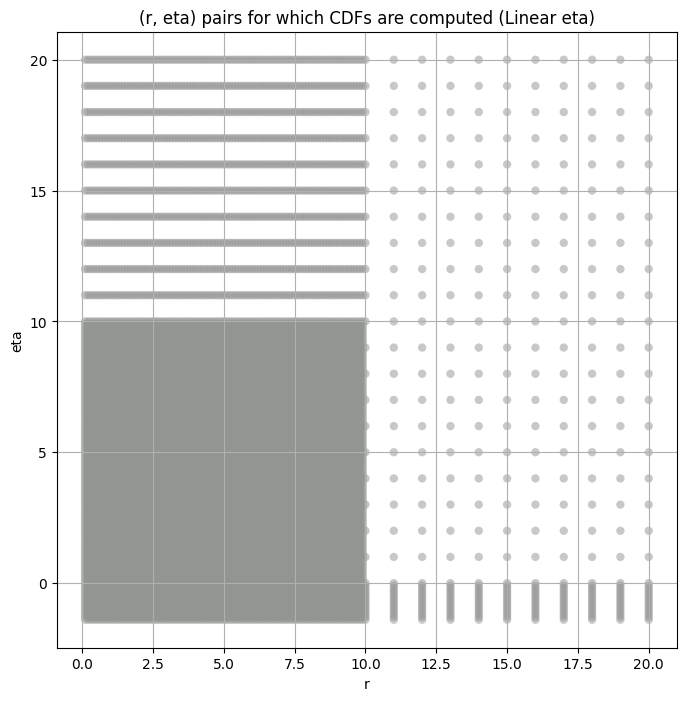

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      3088.534400  2887.459200  3298.715600   2.768599    2.209898   
3       792.086700   742.734500   843.812900   4.083745    3.269665   
4       200.471950   186.644500   214.970100   5.411225    4.463559   
5        46.753990    43.335340    50.343990   6.637358    5.396938   
6        10.640573     9.781947    11.545038   8.303143    6.574237   
7         2.464533     2.255110     2.689189   9.776408    7.589888   
8         0.621601     0.566256     0.683546  11.310019    8.002231   
9         0.189849     0.173479     0.207935  10.419234    7.380879   
10        0.080307     0.074035     0.087240   8.073637    5.321874   

       kurt_upper  total_samples  
layer                             
2        3.385624           7072  
3        5.292534          28288  
4        6.504961         113152  
5        8.449866         452608  
6       11.259625        1810432  
7       14.029722        7241728  
8       23.276373       28966912  
9       20.614819      115867648  
10      15.430704      463470592

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      3088.534400    3088.534424     2729.211670     2512.980713   
3       792.086700     792.086670      752.130188      726.558228   
4       200.471950     200.471954      196.059143      192.828735   
5        46.753990      46.753990       45.578396       44.761612   
6        10.640573      10.640573       10.324841       10.113448   
7         2.464533       2.464533        2.382524        2.329173   
8         0.621601       0.621601        0.598568        0.584417   
9         0.189849       0.189849        0.182920        0.178620   
10        0.080307       0.080307        0.077498        0.075848   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         2342.084473      2201.297852      1972.857910      1786.914429   
3          704.478760       684.908264       651.283752       622.598022   
4          190.056839       187.578033       183.187927       179.288940   
5           44.062187        43.431717        42.310799        41.323174   
6            9.934249         9.775035         9.492994         9.244202   
7            2.284063         2.243942         2.173212         2.111302   
8            0.572523         0.561991         0.543549         0.527494   
9            0.175024         0.171851         0.166327         0.161546   
10           0.074489         0.073303         0.071269         0.069535   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          1628.848389      1492.186157      1371.725952      1082.270264  
3           597.337097       574.518860       553.665710       500.551422  
4           175.749542       172.464813       169.376877       161.196945  
5            40.422737        39.587730        38.812019        36.746922  
6             9.019217         8.812799         8.621868         8.117689  
7             2.055693         2.004905         1.957958         1.834303  
8             0.513107         0.499991         0.487896         0.456180  
9             0.157285         0.153418         0.149863         0.140589  
10            0.068007         0.066634         0.065381         0.062145

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.008792199573502413 3088.5344


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.009429455384014407 2729.2117


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.01461905570986366 2512.9807


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.01919398764523117 2342.0845


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.023460725504885538 2201.2979


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.030937585493713393 1972.8579


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.03821453035107569 1786.9144


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.04579532689147203 1628.8484


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.05323758600972006 1492.1862


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.060642106283458674 1371.726


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.08076822760340419 1082.2703
Number of samples: 7072, Without approximation : 7072


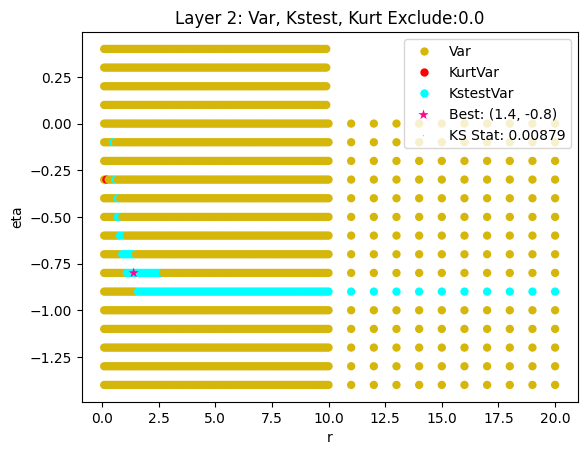

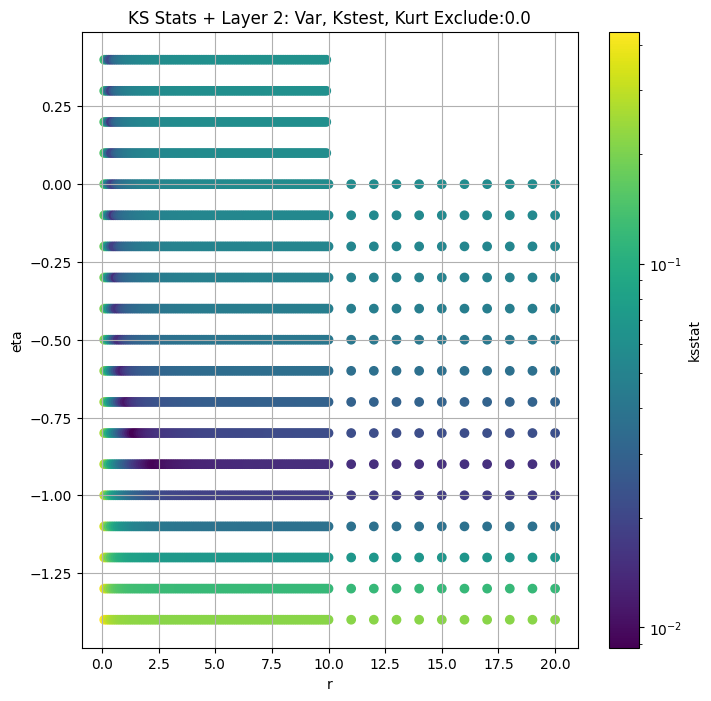

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.007428552916679543 792.0867


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.007582041026313435 752.1302


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.007704346619786806 726.5582


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.0078177604231352 704.47876


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.008208129248103678 684.90826


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.009148584748179929 651.28375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.011482227543140149 622.598


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.01397257789652482 597.3371


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.016286423131282535 574.51886


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.01854478692272328 553.6657


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.02466282668058746 500.55142
Number of samples: 28288, Without approximation : 28288


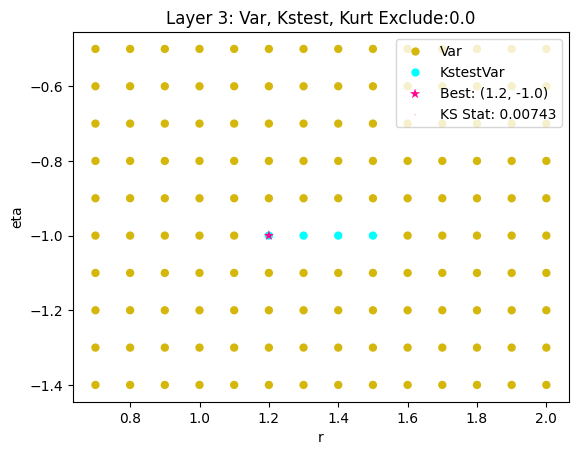

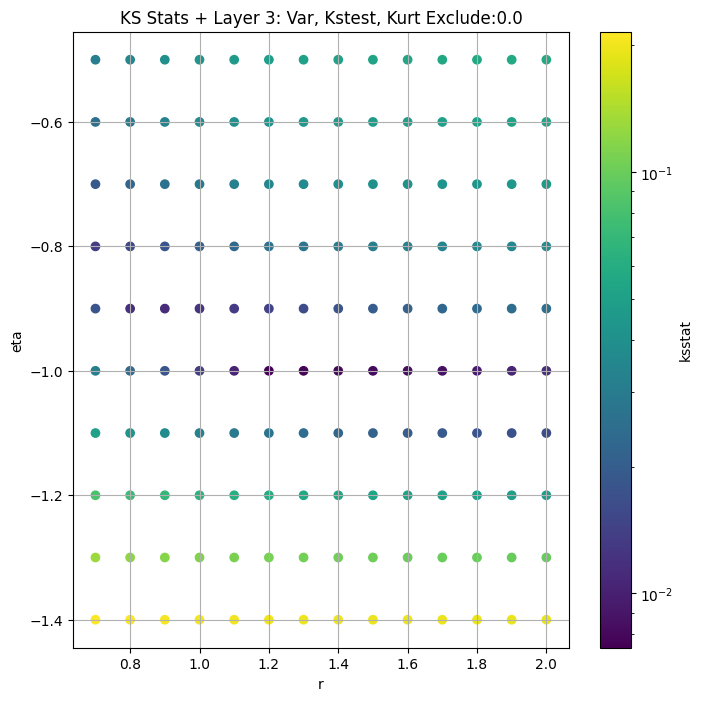

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.009980931498212553 200.47195


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.009937081900030176 196.05914


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.010122213222521048 192.82874


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.010067573276103858 190.05684


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.010017789386991827 187.57803


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.010207806842577383 183.18793


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.010110710724745009 179.28894


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.010241066116911779 175.74954


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.010384686670218968 172.46481


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.010304425358244718 169.37688


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.010599074956828547 161.19695
Number of samples: 100000, Without approximation : 113152


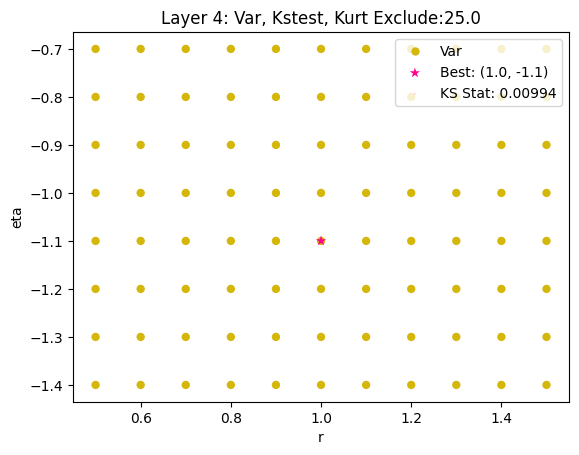

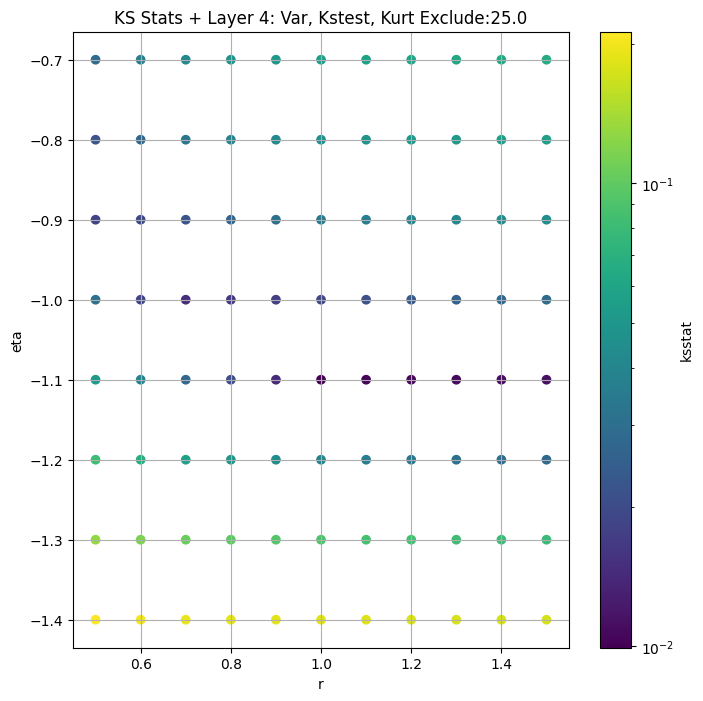

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.01687999999999995 46.75399


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.01687999999999995 45.578396


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.01687999999999995 44.761612


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.01687999999999995 44.062187


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.01687999999999995 43.431717


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.01687999999999995 42.3108


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.01687999999999995 41.323174


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.01687999999999995 40.422737


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.01687999999999995 39.58773


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.01687999999999995 38.81202


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.01687999999999995 36.74692
Number of samples: 100000, Without approximation : 452608


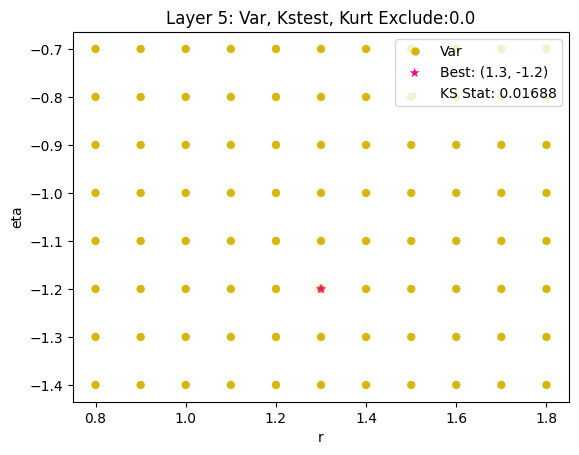

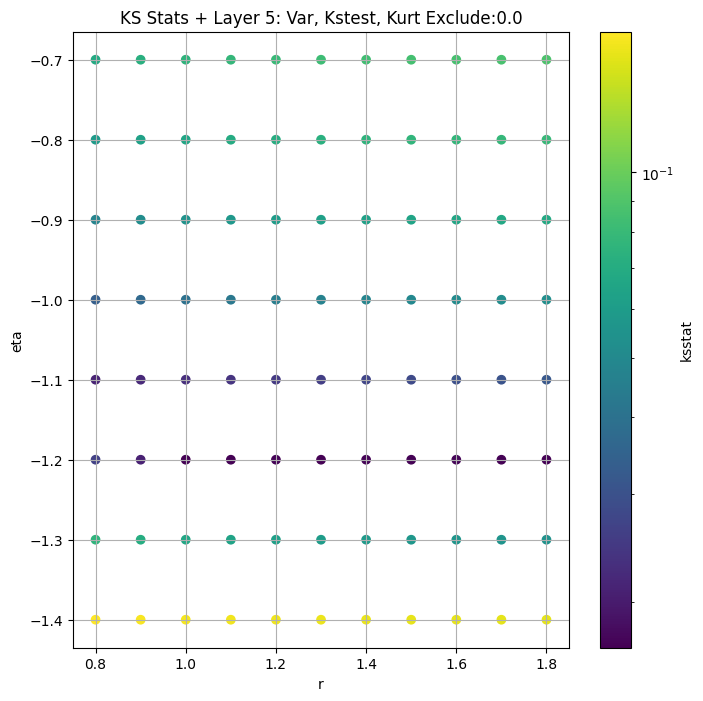

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.036719999999999864 10.640573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.036719999999999864 10.3248415


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.036719999999999864 10.113448


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.036719999999999864 9.934249


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.036719999999999864 9.775035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.036719999999999864 9.492994


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.036719999999999864 9.244202


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.036719999999999864 9.0192175


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.036719999999999864 8.8127985


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.036719999999999864 8.621868


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.036719999999999864 8.117689
Number of samples: 100000, Without approximation : 1810432


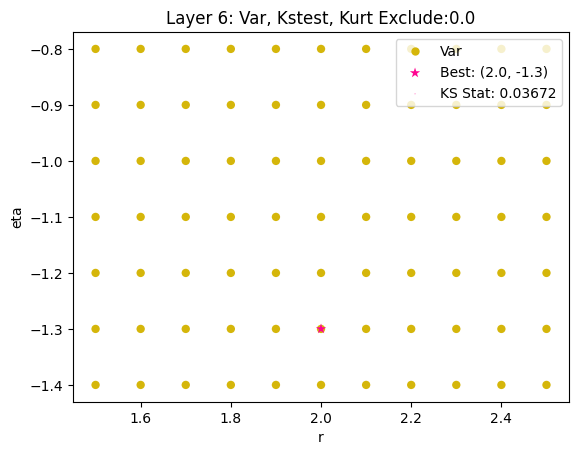

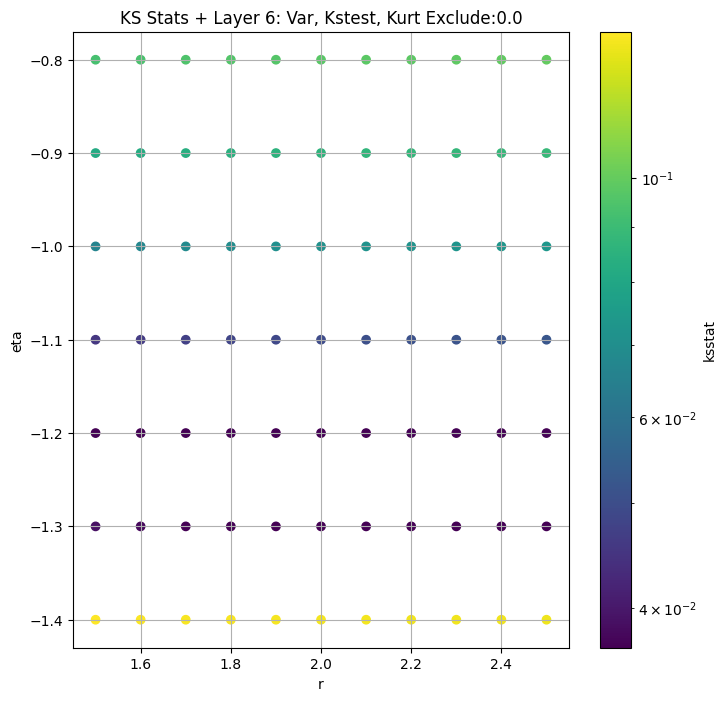

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.07140999999999975 2.464533


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.07140999999999975 2.382524


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.07140999999999975 2.3291726


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.07140999999999975 2.2840629


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.07140999999999975 2.2439415


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.07140999999999975 2.1732116


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.07140999999999975 2.1113017


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.07140999999999975 2.055693


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.07140999999999975 2.0049047


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.07140999999999975 1.9579576


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.07140999999999975 1.8343027
Number of samples: 100000, Without approximation : 7241728


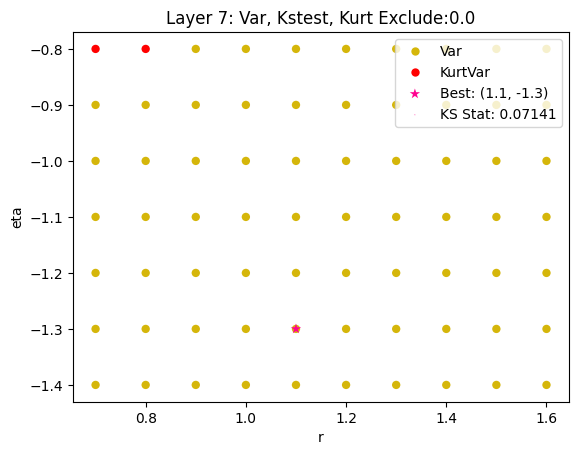

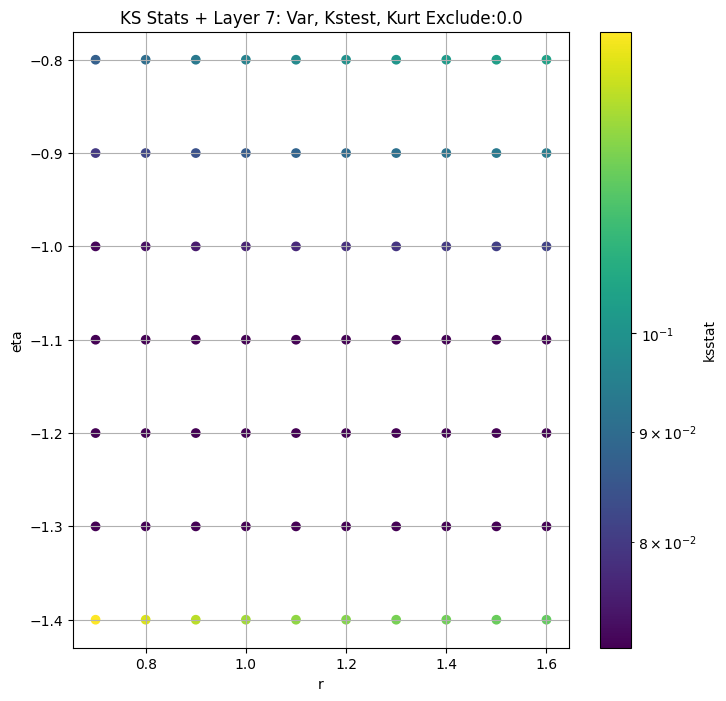

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.11531999999999976 0.6216006


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.11531999999999976 0.5985679


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.11531999999999976 0.5844165


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.11531999999999976 0.57252294


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.11531999999999976 0.5619906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.11531999999999976 0.5435495


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.11531999999999976 0.5274944


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.11531999999999976 0.513107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.11531999999999976 0.49999127


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.11531999999999976 0.48789582


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.11531999999999976 0.45618048
Number of samples: 100000, Without approximation : 28966912


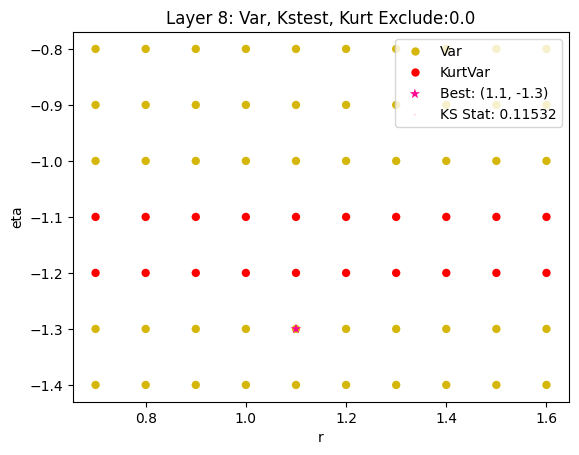

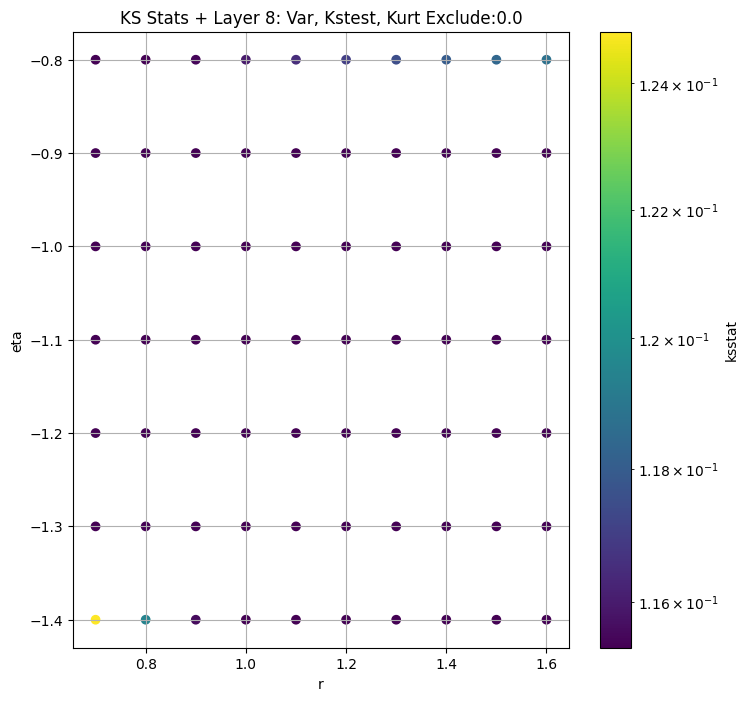

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.16193999999999975 0.18984902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.16193999999999975 0.18291979


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.16193999999999975 0.17862013


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.16193999999999975 0.17502415


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.16193999999999975 0.17185132


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.16193999999999975 0.16632728


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.16193999999999975 0.16154636


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.16193999999999975 0.15728539


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.16193999999999975 0.1534178


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.16193999999999975 0.14986317


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.16193999999999975 0.14058897
Number of samples: 100000, Without approximation : 115867648


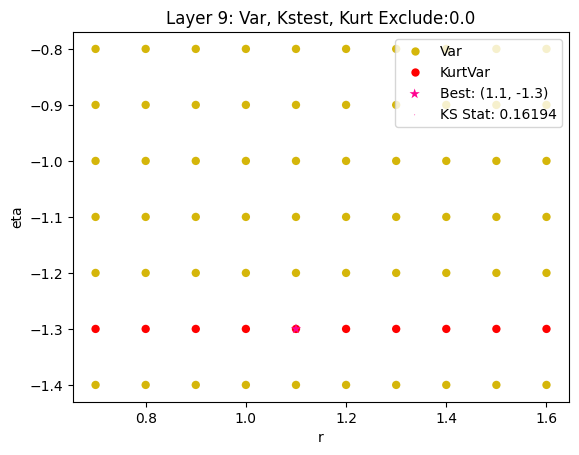

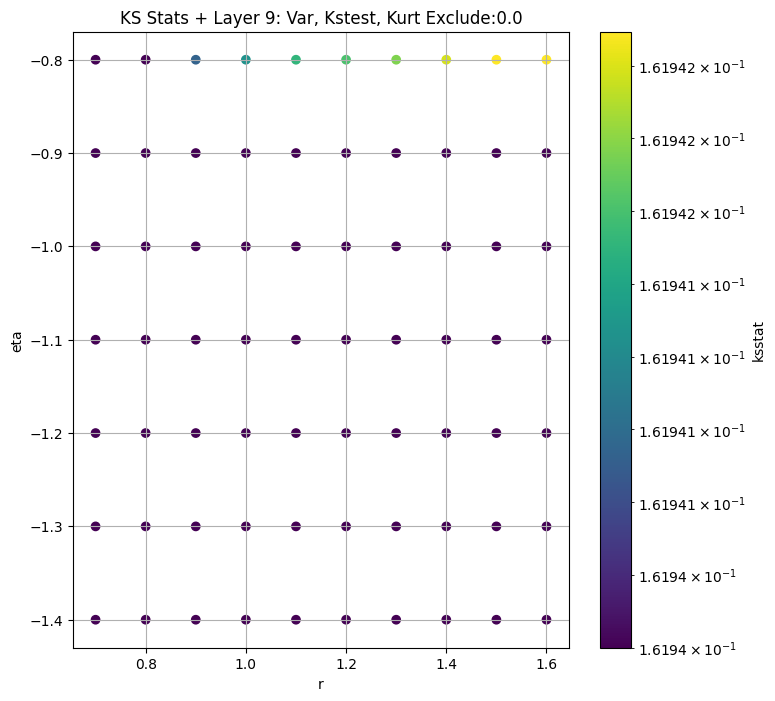

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.20881999999999978 0.080307364


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.20881999999999978 0.07749791


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.20881999999999978 0.07584751


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.20881999999999978 0.07448898


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.20881999999999978 0.07330347


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.20881999999999978 0.07126861


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.20881999999999978 0.069534644


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.20881999999999978 0.06800734


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.20881999999999978 0.06663392


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.20881999999999978 0.06538084


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.20881999999999978 0.062144794
Number of samples: 100000, Without approximation : 463470592


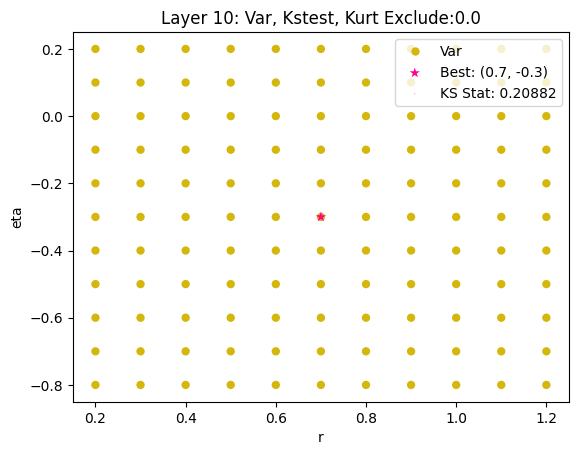

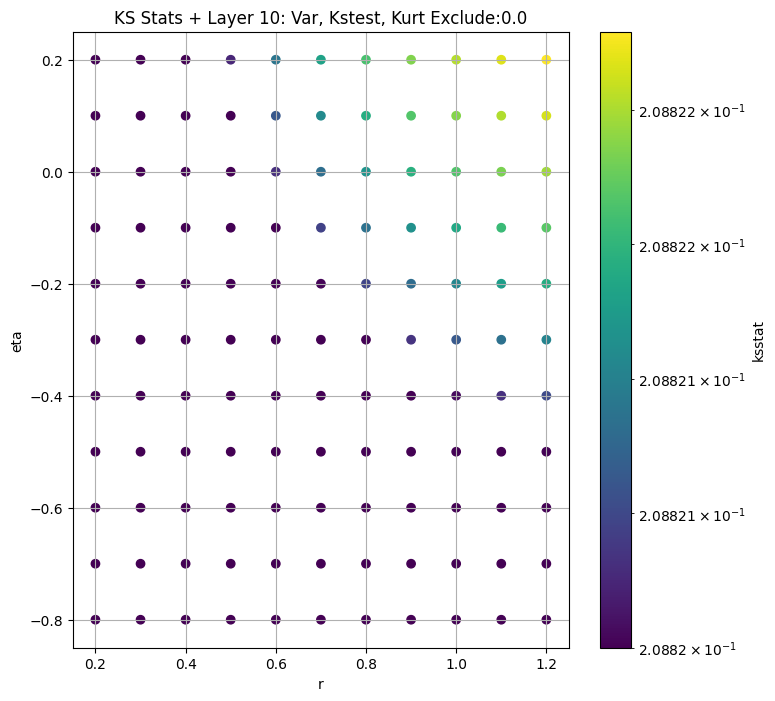

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      3088.534400  2887.459200  3298.715600   2.768599    2.209898   
3       792.086700   742.734500   843.812900   4.083745    3.269665   
4       200.471950   186.644500   214.970100   5.411225    4.463559   
5        46.753990    43.335340    50.343990   6.637358    5.396938   
6        10.640573     9.781947    11.545038   8.303143    6.574237   
7         2.464533     2.255110     2.689189   9.776408    7.589888   
8         0.621601     0.566256     0.683546  11.310019    8.002231   
9         0.189849     0.173479     0.207935  10.419234    7.380879   
10        0.080307     0.074035     0.087240   8.073637    5.321874   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.385624           7072             0.008792        1.4         -0.8   
3        5.292534          28288             0.007429        1.2         -1.0   
4        6.504961         113152             0.009937        1.0         -1.1   
5        8.449866         452608             0.016880        1.3         -1.2   
6       11.259625        1810432             0.036720        2.0         -1.3   
7       14.029722        7241728             0.071410        1.1         -1.3   
8       23.276373       28966912             0.115320        1.1         -1.3   
9       20.614819      115867648             0.161940        1.1         -1.3   
10      15.430704      463470592             0.208820        0.7         -0.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        5986.076832                     0.0         3088.534400   
3        1859.228795                     0.0          792.086700   
4         490.147858                    25.0          196.059140   
5         184.483851                     0.0           46.753990   
6          67.975890                     0.0           10.640573   
7          13.102503                     0.0            2.464533   
8           3.304693                     0.0            0.621601   
9           1.009318                     0.0            0.189849   
10          0.031950                     0.0            0.080307   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.016126  
3                     0.008069  
4                     0.004036  
5                     0.002018  
6                     0.001009  
7                     0.000505  
8                     0.000252  
9                     0.000126  
10                    0.000063

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.025377316661226557, var: 2201.2978515625


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.021290910053854972, var: 2342.08447265625


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.016870669623871404, var: 2512.980712890625


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.012051775711933832, var: 2729.211669921875


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.0076599406662697656, var: 3088.534423828125
Number of samples: 7072, Without approximation : 7072


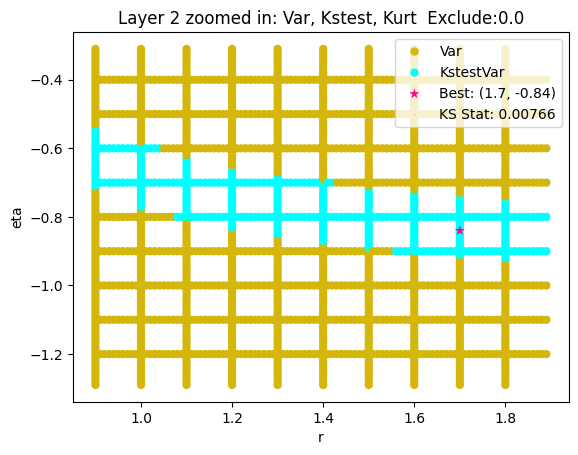

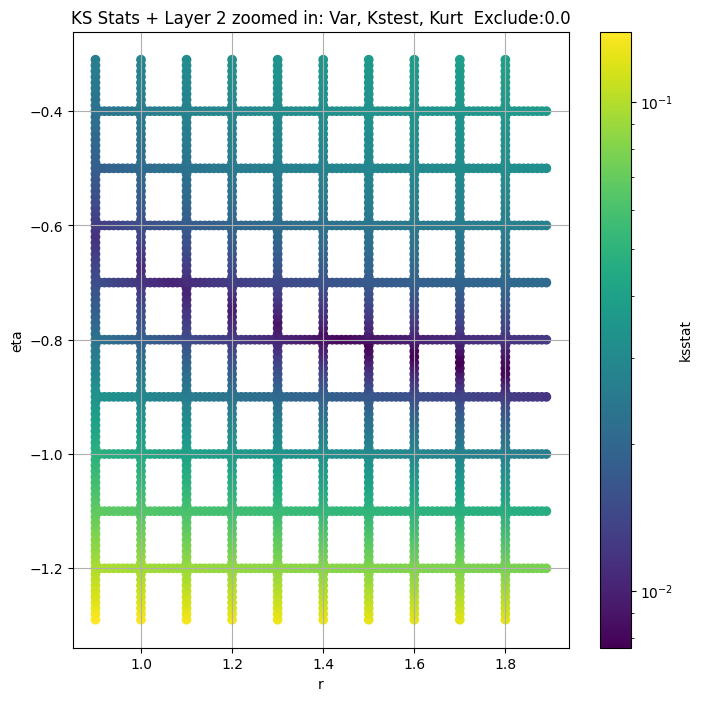

Layer 3


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.00984601157274212, var: 684.9082641601562


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.008238333831792718, var: 704.478759765625


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.007604700376770301, var: 726.5582275390625


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.0070524429349302364, var: 752.1301879882812


  0%|          | 0/1665 [00:00<?, ?it/s]

Finding Minimum after computing 1665 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.006643598460544409, var: 792.086669921875
Number of samples: 28288, Without approximation : 28288


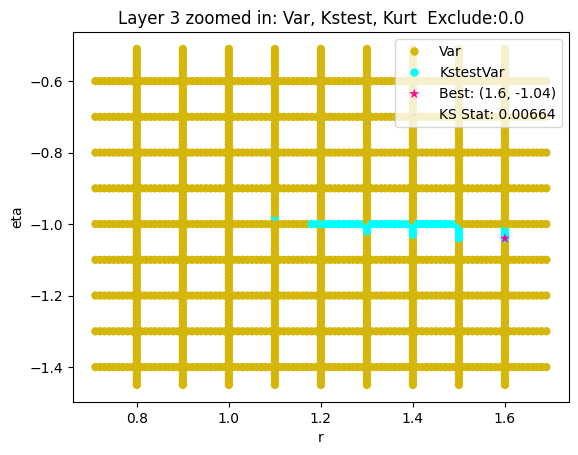

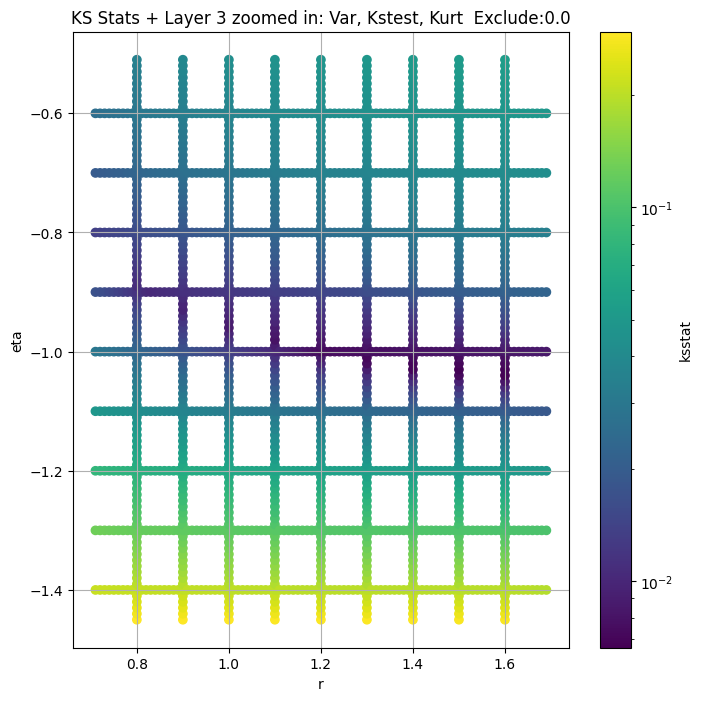

Layer 4


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 4, 25.0 + 100 = 125, ksstat: 0.009371311407951, var: 185.3153533935547


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 4, 25.0 + 75 = 100, ksstat: 0.009390451657734222, var: 187.57803344726562


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 4, 25.0 + 50 = 75, ksstat: 0.009411035732190043, var: 190.0568389892578


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 4, 25.0 + 25 = 50, ksstat: 0.009366512222054979, var: 192.8287353515625


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 4, 25.0 + 0 = 25, ksstat: 0.009197238484601855, var: 196.05914306640625


  0%|          | 0/1485 [00:00<?, ?it/s]

Finding Minimum after computing 1485 CDFs
layer 4, 25.0 + -25 = 0, ksstat: 0.00922989948681241, var: 200.47195434570312
Number of samples: 100000, Without approximation : 113152


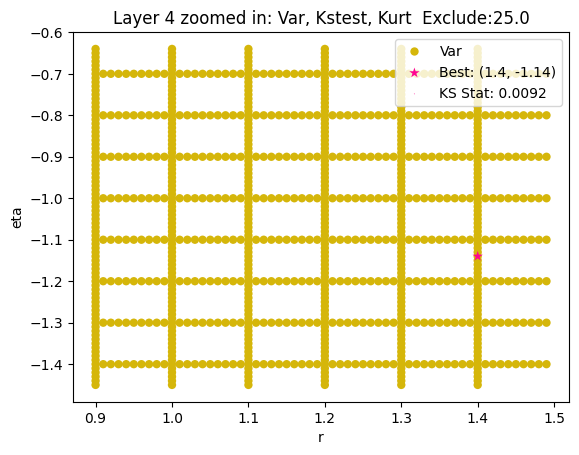

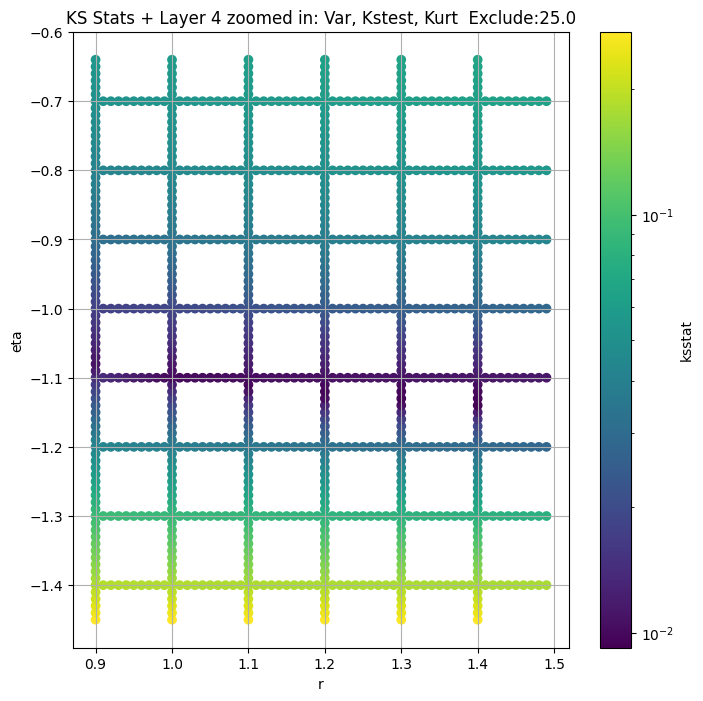

Layer 5


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.016879999999999895, var: 43.43171691894531


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.016879999999999895, var: 44.06218719482422


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.016879999999999895, var: 44.76161193847656


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.016879999999999895, var: 45.57839584350586


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.016879999999999895, var: 46.753990173339844
Number of samples: 100000, Without approximation : 452608


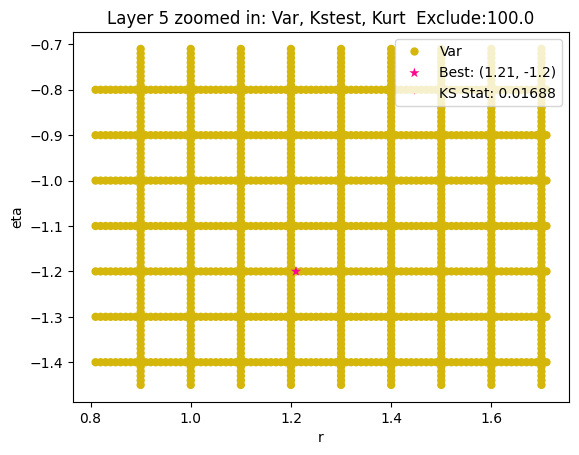

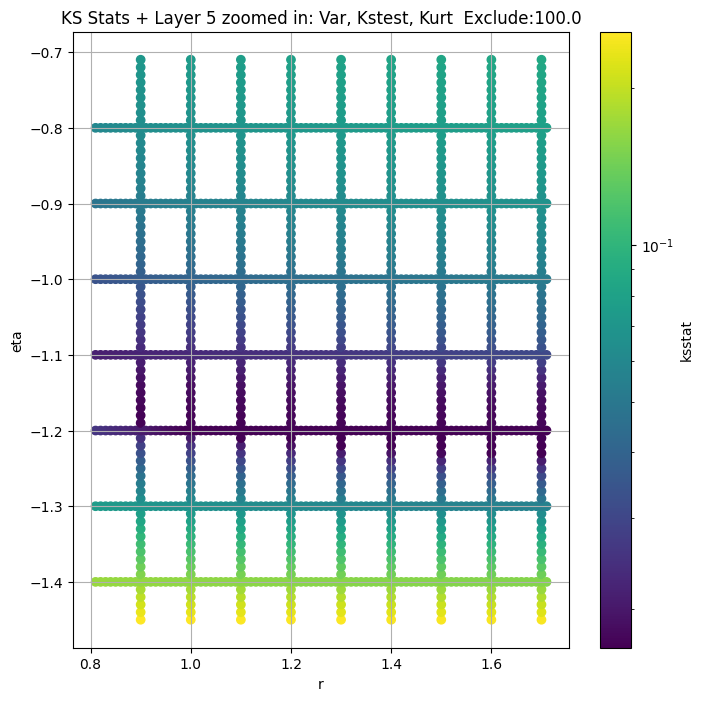

Layer 6


  0%|          | 0/619 [00:00<?, ?it/s]

Finding Minimum after computing 619 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.036719999999999864, var: 9.77503490447998


  0%|          | 0/619 [00:00<?, ?it/s]

Finding Minimum after computing 619 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.036719999999999864, var: 9.934248924255371


  0%|          | 0/619 [00:00<?, ?it/s]

Finding Minimum after computing 619 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.036719999999999864, var: 10.113448143005371


  0%|          | 0/619 [00:00<?, ?it/s]

Finding Minimum after computing 619 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.036719999999999864, var: 10.324841499328613


  0%|          | 0/619 [00:00<?, ?it/s]

Finding Minimum after computing 619 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.036719999999999864, var: 10.640572547912598
Number of samples: 100000, Without approximation : 1810432


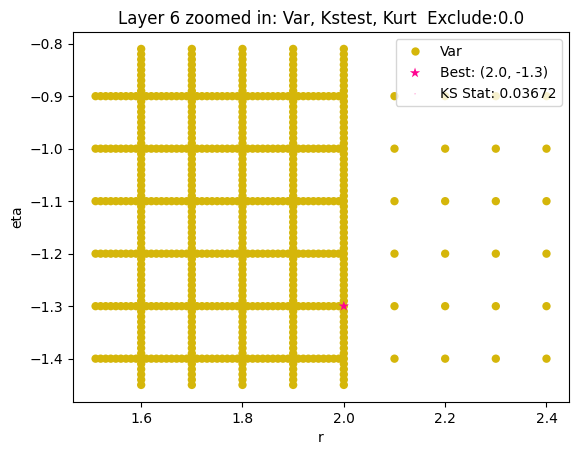

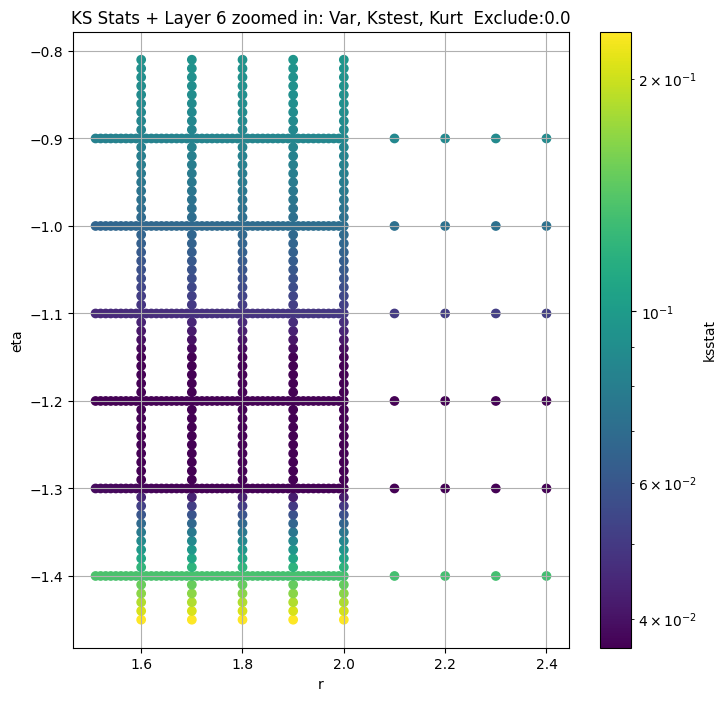

Layer 7


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.07140999999999975, var: 2.24394154548645


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.07140999999999975, var: 2.2840628623962402


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.07140999999999975, var: 2.3291726112365723


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.07140999999999975, var: 2.382524013519287


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.07140999999999975, var: 2.4645330905914307
Number of samples: 100000, Without approximation : 7241728


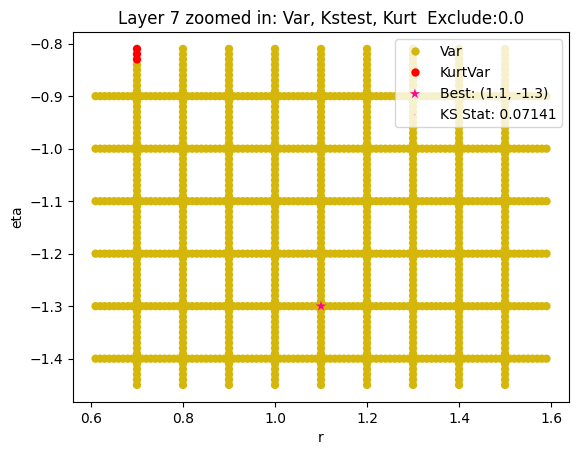

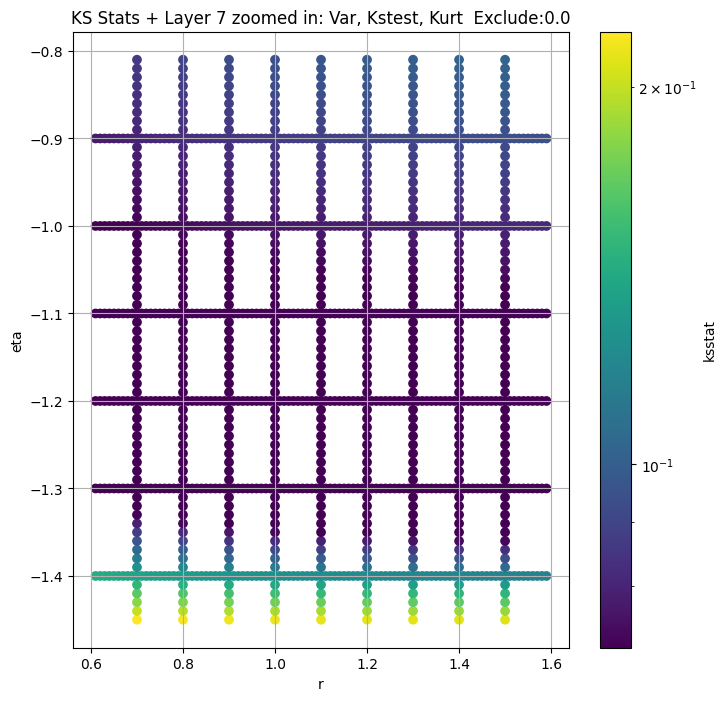

Layer 8


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.11531999999999976, var: 0.5619906187057495


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.11531999999999976, var: 0.5725229382514954


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.11531999999999976, var: 0.5844165086746216


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.11531999999999976, var: 0.5985679030418396


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.11531999999999976, var: 0.6216006278991699
Number of samples: 100000, Without approximation : 28966912


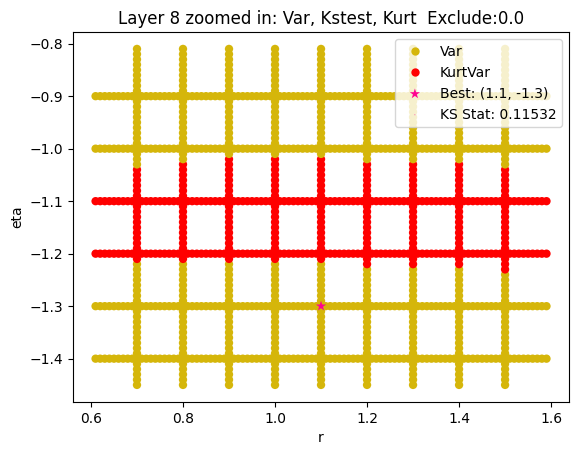

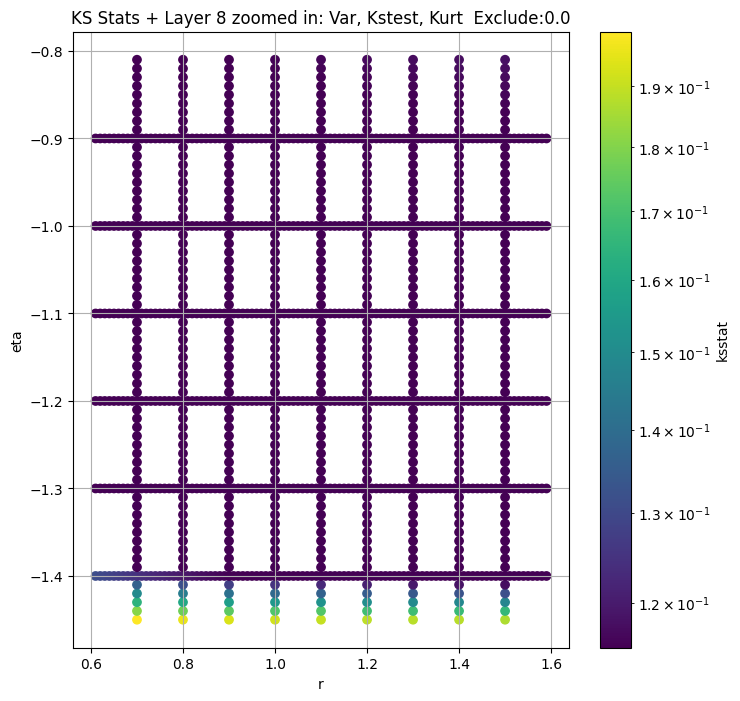

Layer 9


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 100 = 100, ksstat: 0.16193999999999975, var: 0.17185132205486298


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 75 = 75, ksstat: 0.16193999999999975, var: 0.175024151802063


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 50 = 50, ksstat: 0.16193999999999975, var: 0.1786201298236847


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 25 = 25, ksstat: 0.16193999999999975, var: 0.18291978538036346


  0%|          | 0/1125 [00:00<?, ?it/s]

Finding Minimum after computing 1125 CDFs
layer 9, 0.0 + 0 = 0, ksstat: 0.16193999999999975, var: 0.18984901905059814
Number of samples: 100000, Without approximation : 115867648


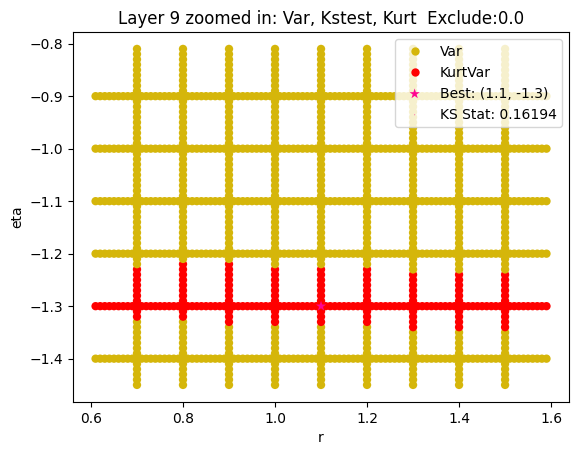

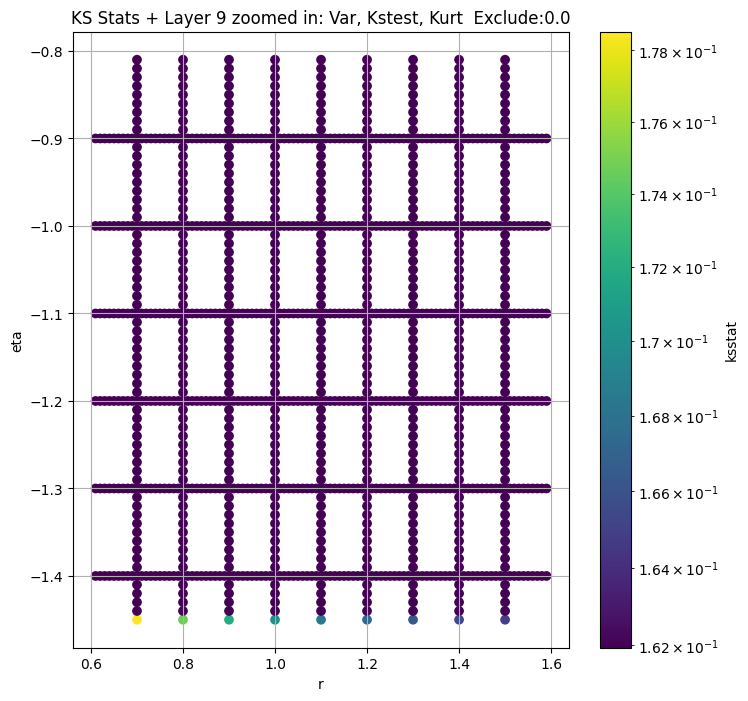

Layer 10


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 10, 0.0 + 100 = 100, ksstat: 0.20881999999999978, var: 0.0733034685254097


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 10, 0.0 + 75 = 75, ksstat: 0.20881999999999978, var: 0.07448898255825043


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 10, 0.0 + 50 = 50, ksstat: 0.20881999999999978, var: 0.07584750652313232


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 10, 0.0 + 25 = 25, ksstat: 0.20881999999999978, var: 0.07749790698289871


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 10, 0.0 + 0 = 0, ksstat: 0.20881999999999978, var: 0.08030736446380615
Number of samples: 100000, Without approximation : 463470592


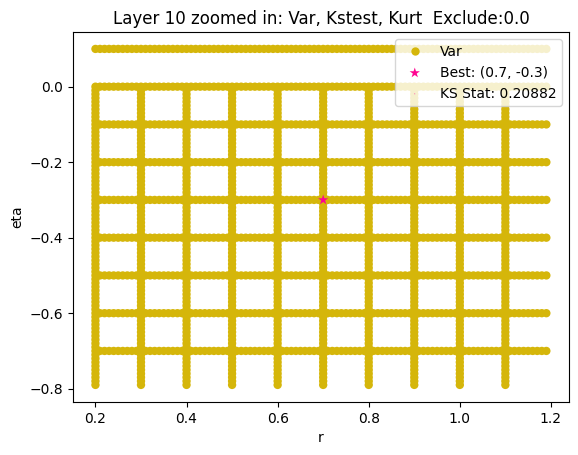

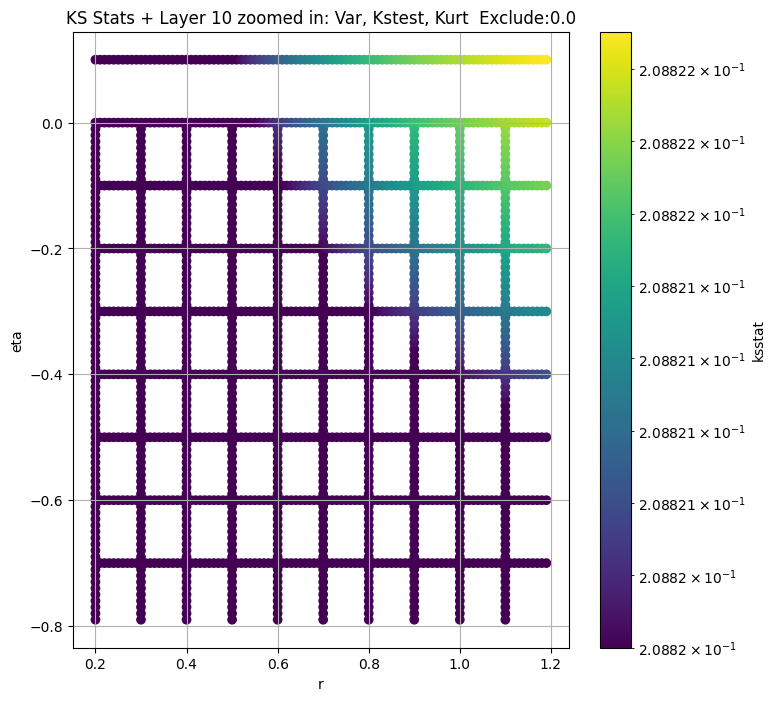

Not a fit


obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      3088.534400  2887.459200  3298.715600   2.768599    2.209898   
3       792.086700   742.734500   843.812900   4.083745    3.269665   
4       200.471950   186.644500   214.970100   5.411225    4.463559   
5        46.753990    43.335340    50.343990   6.637358    5.396938   
6        10.640573     9.781947    11.545038   8.303143    6.574237   
7         2.464533     2.255110     2.689189   9.776408    7.589888   
8         0.621601     0.566256     0.683546  11.310019    8.002231   
9         0.189849     0.173479     0.207935  10.419234    7.380879   
10        0.080307     0.074035     0.087240   8.073637    5.321874   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.385624           7072             0.008792        1.4         -0.8   
3        5.292534          28288             0.007429        1.2         -1.0   
4        6.504961         113152             0.009937        1.0         -1.1   
5        8.449866         452608             0.016880        1.3         -1.2   
6       11.259625        1810432             0.036720        2.0         -1.3   
7       14.029722        7241728             0.071410        1.1         -1.3   
8       23.276373       28966912             0.115320        1.1         -1.3   
9       20.614819      115867648             0.161940        1.1         -1.3   
10      15.430704      463470592             0.208820        0.7         -0.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2        5986.076832                     0.0         3088.534424   
3        1859.228795                     0.0          792.086670   
4         490.147858                    25.0          196.059143   
5         184.483851                     0.0           43.431717   
6          67.975890                     0.0           10.640573   
7          13.102503                     0.0            2.464533   
8           3.304693                     0.0            0.621601   
9           1.009318                     0.0            0.189849   
10          0.031950                     0.0            0.080307   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.016126          0.007660    1.70     -0.84   
3                     0.008069          0.006644    1.60     -1.04   
4                     0.004036          0.009197    1.40     -1.14   
5                     0.002018          0.016880    1.21     -1.20   
6                     0.001009          0.036720    2.00     -1.30   
7                     0.000505          0.071410    1.10     -1.30   
8                     0.000252          0.115320    1.10     -1.30   
9                     0.000126          0.161940    1.10     -1.30   
10                    0.000063          0.208820    0.70     -0.30   

        best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                 
2      6965.564615                  0.0        30207  
3      2340.555329                  0.0        42432  
4       678.239859                 25.0        21216  
5       165.095489                100.0         6712  
6        67.975890                  0.0         1326  
7        13.102503                  0.0          372  
8         3.304693                  0.0          138  
9         1.009318                  0.0           67  
10        0.031950                  0.0           -1

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

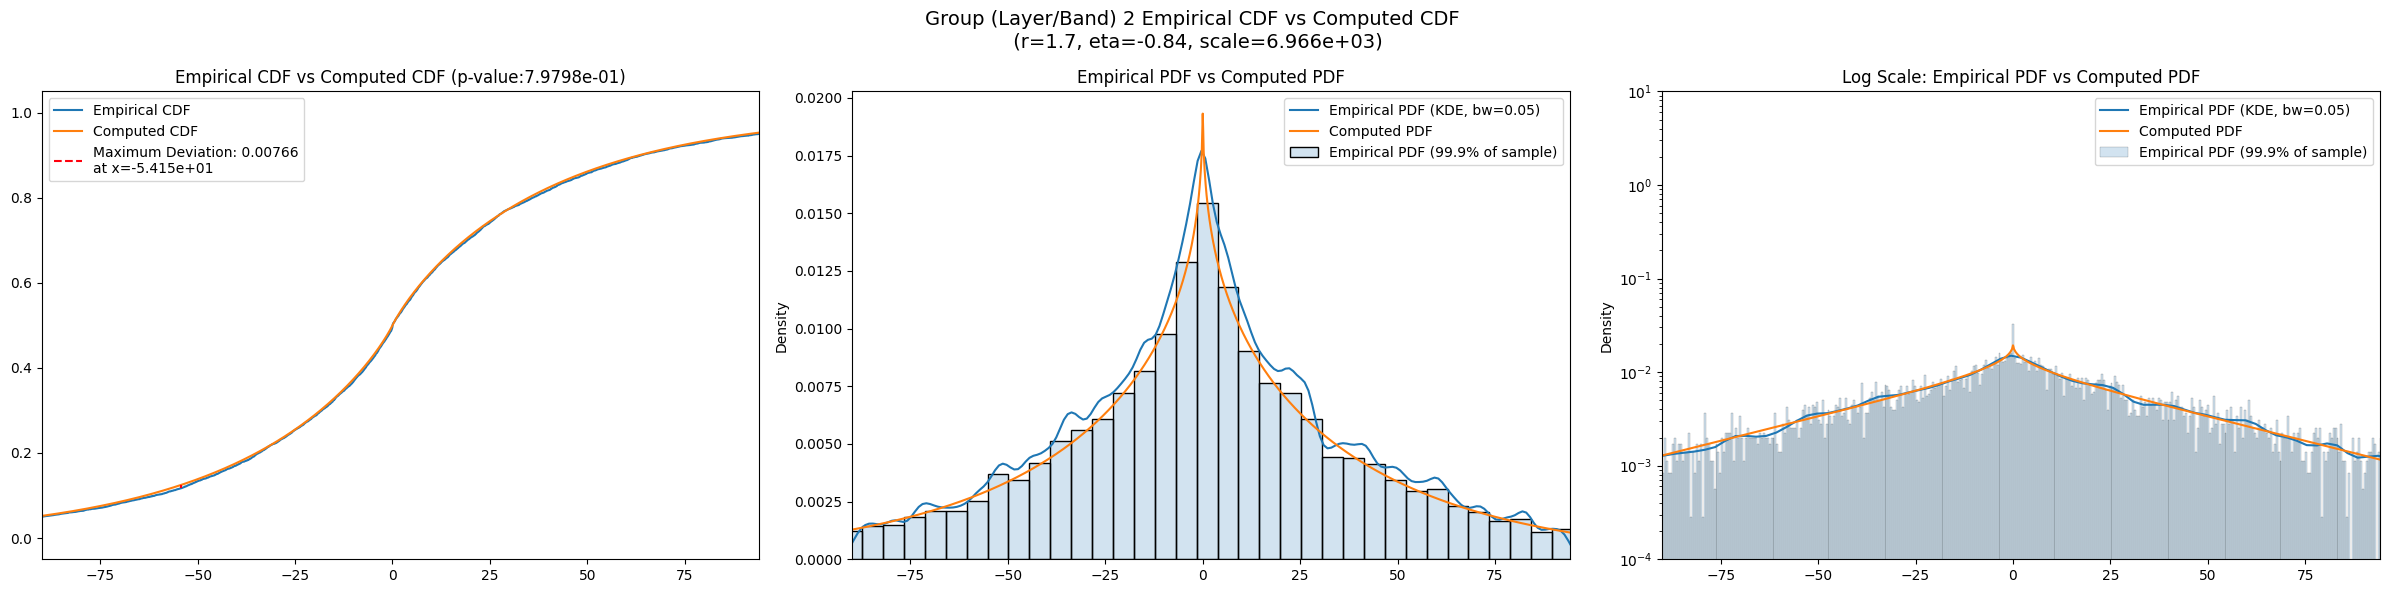

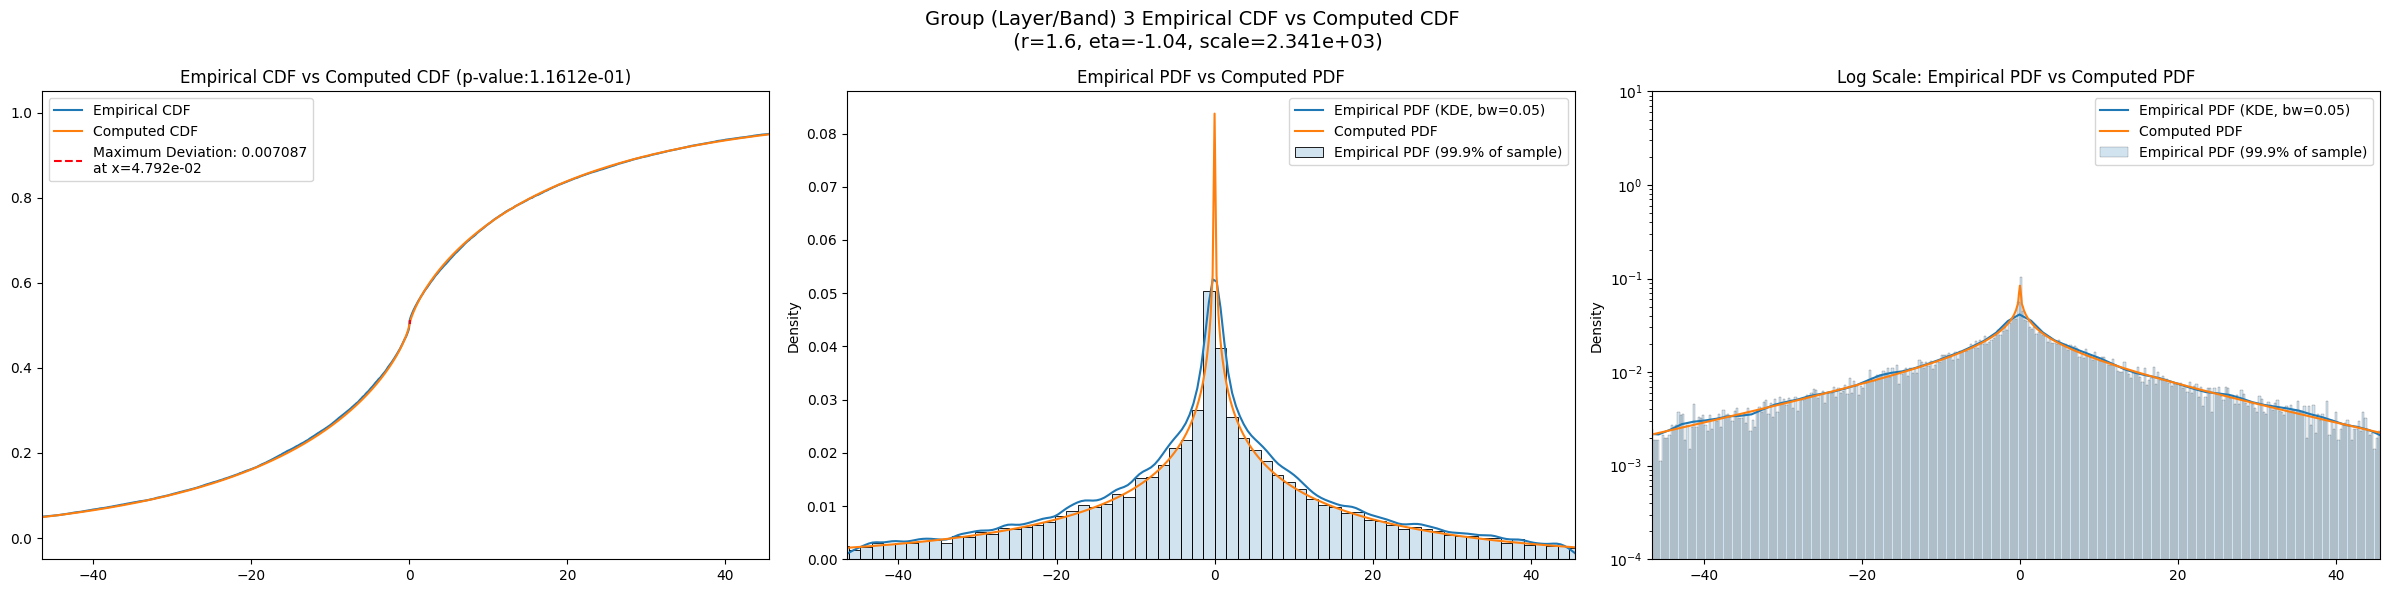

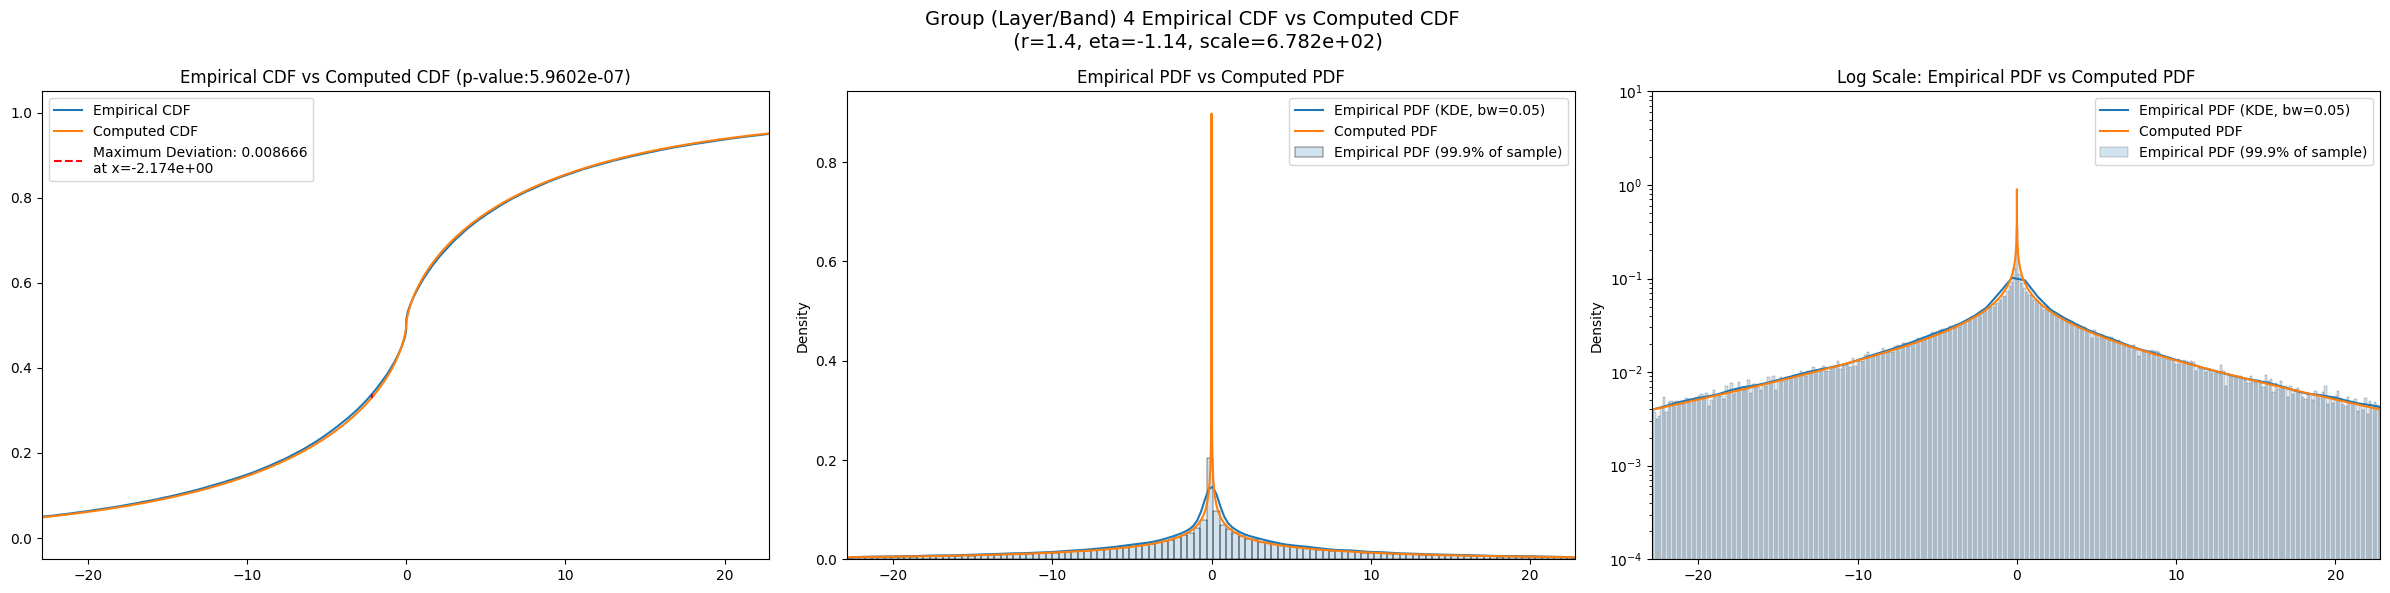

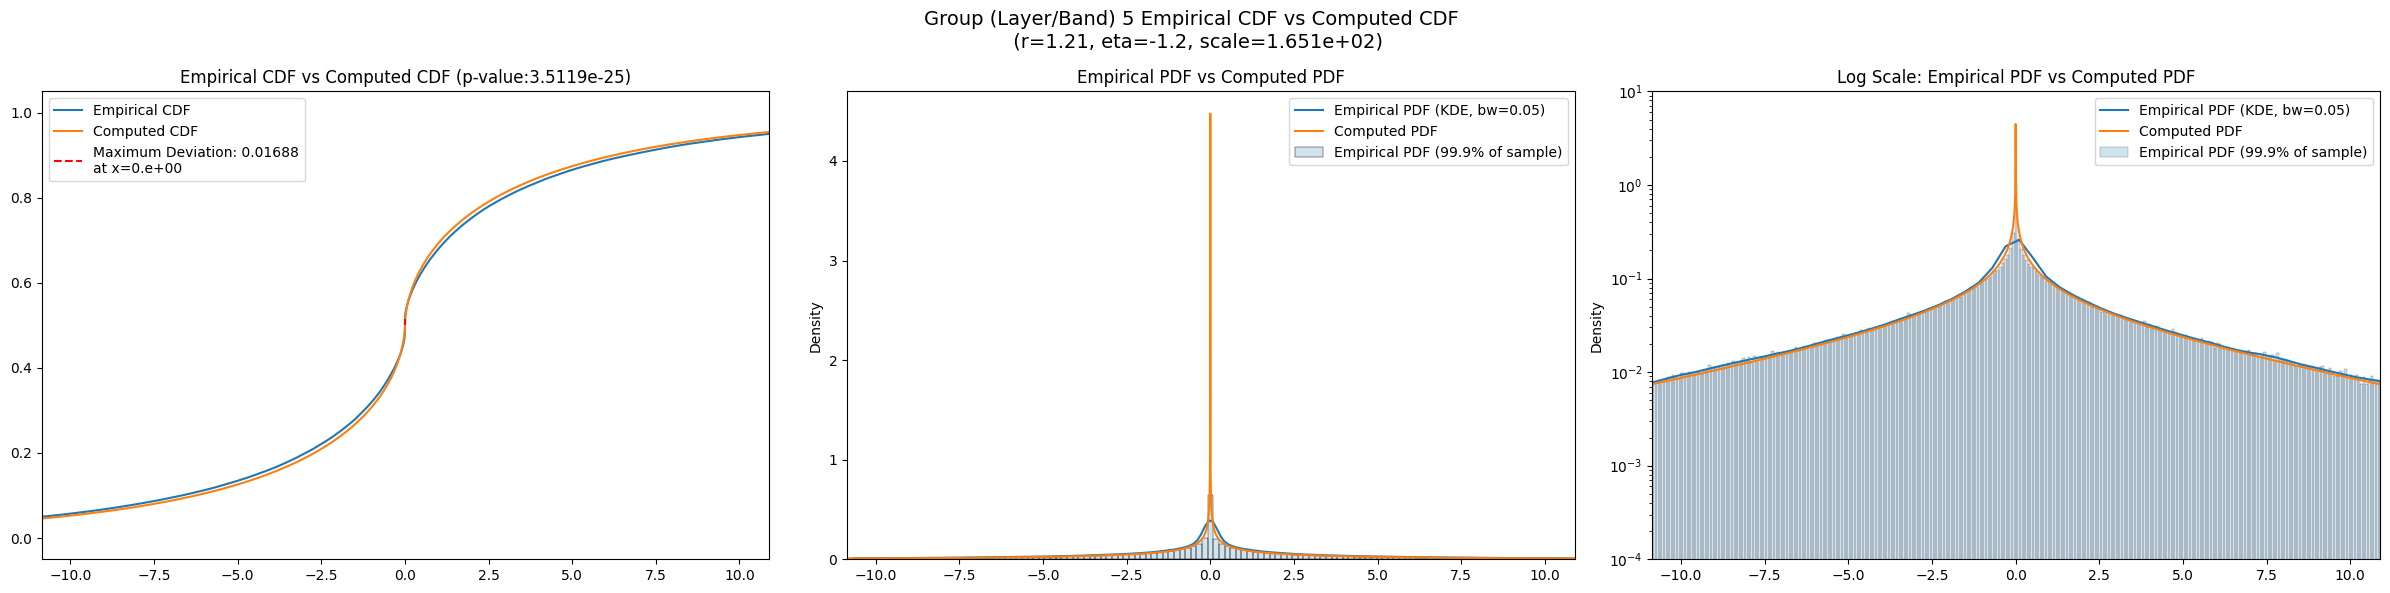

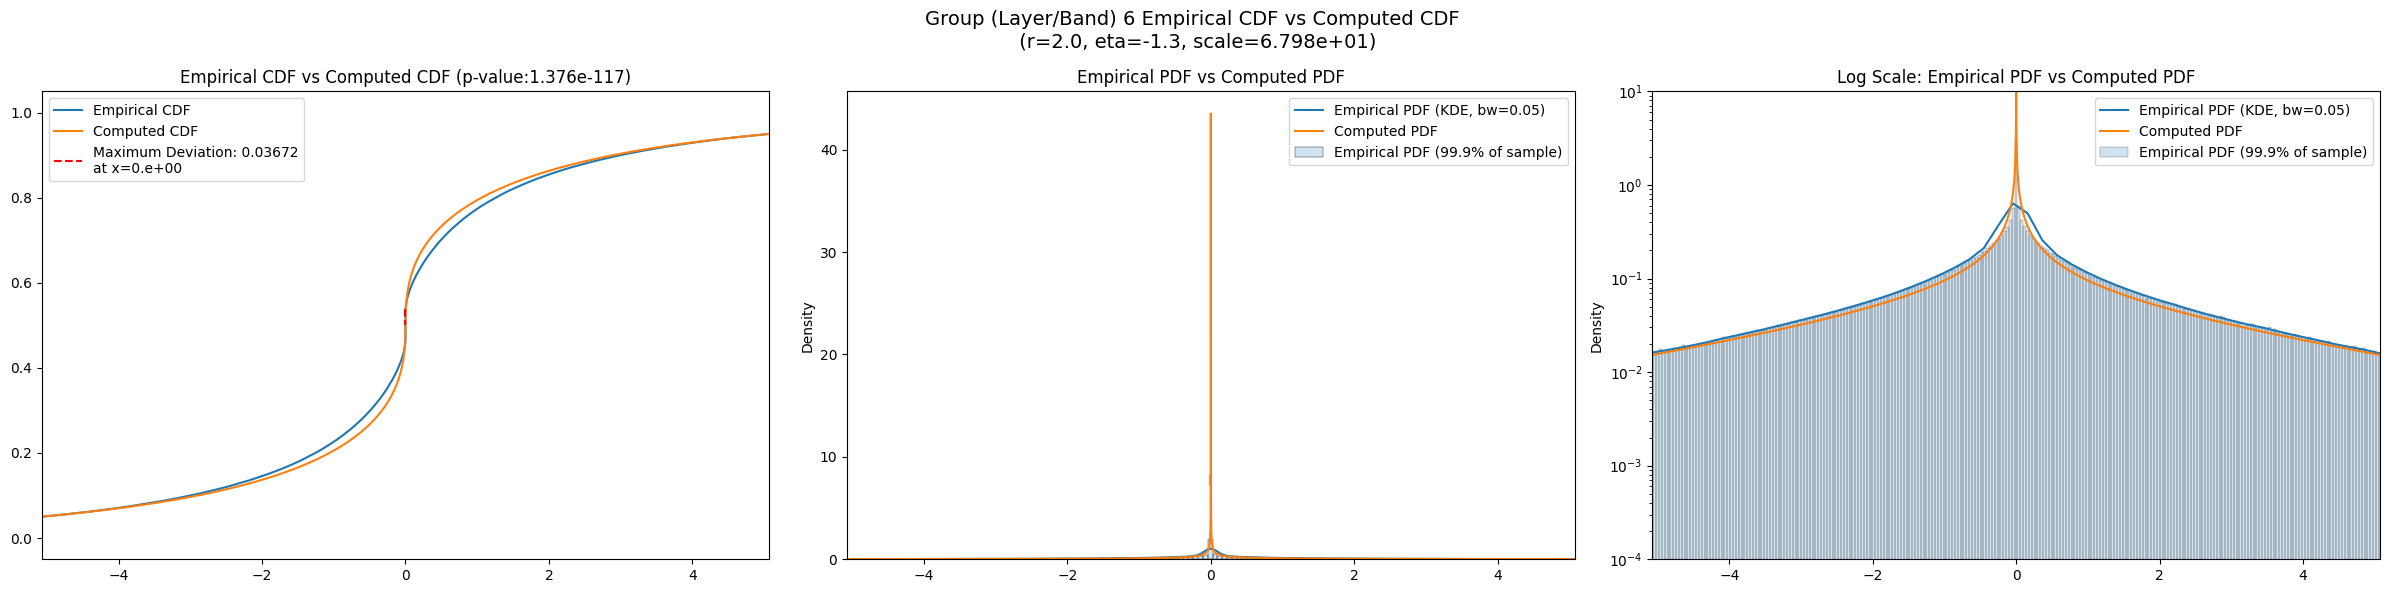

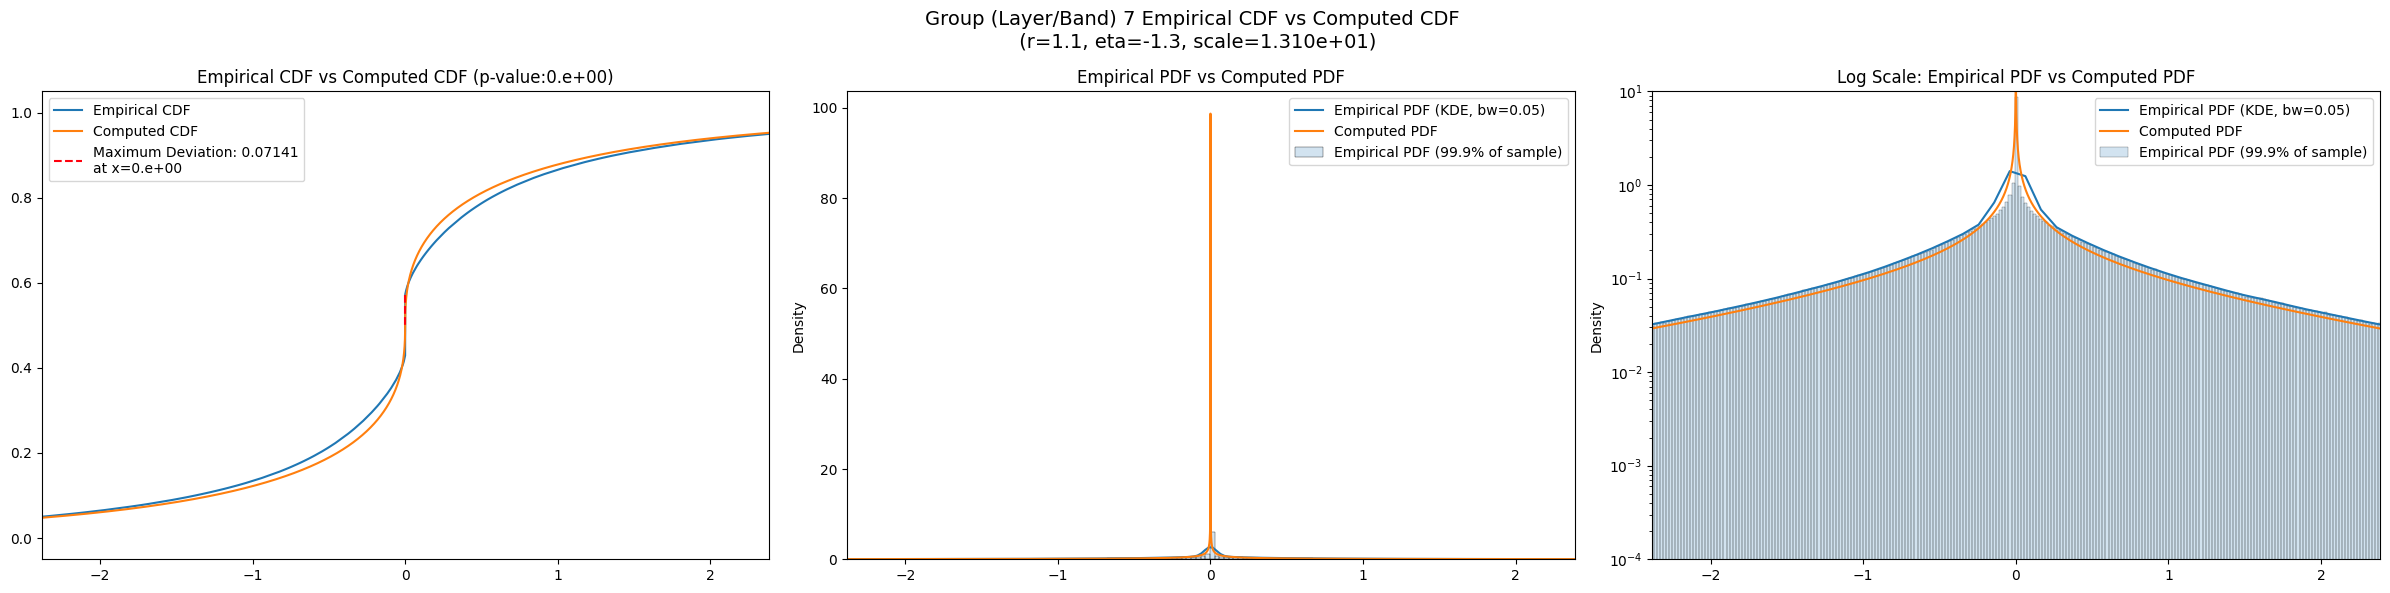

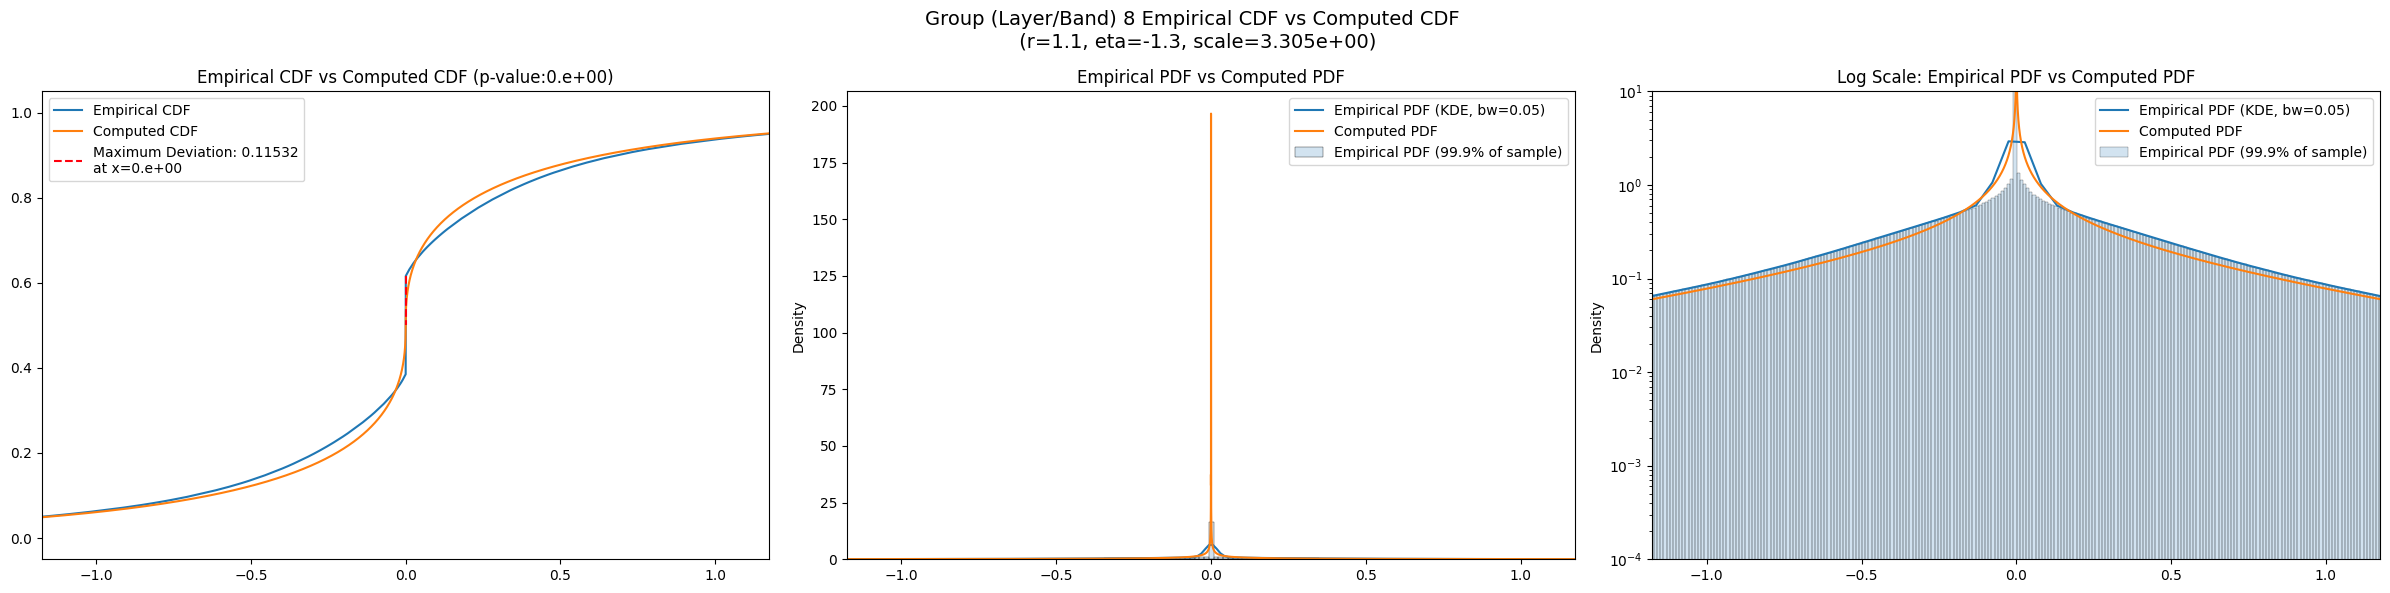

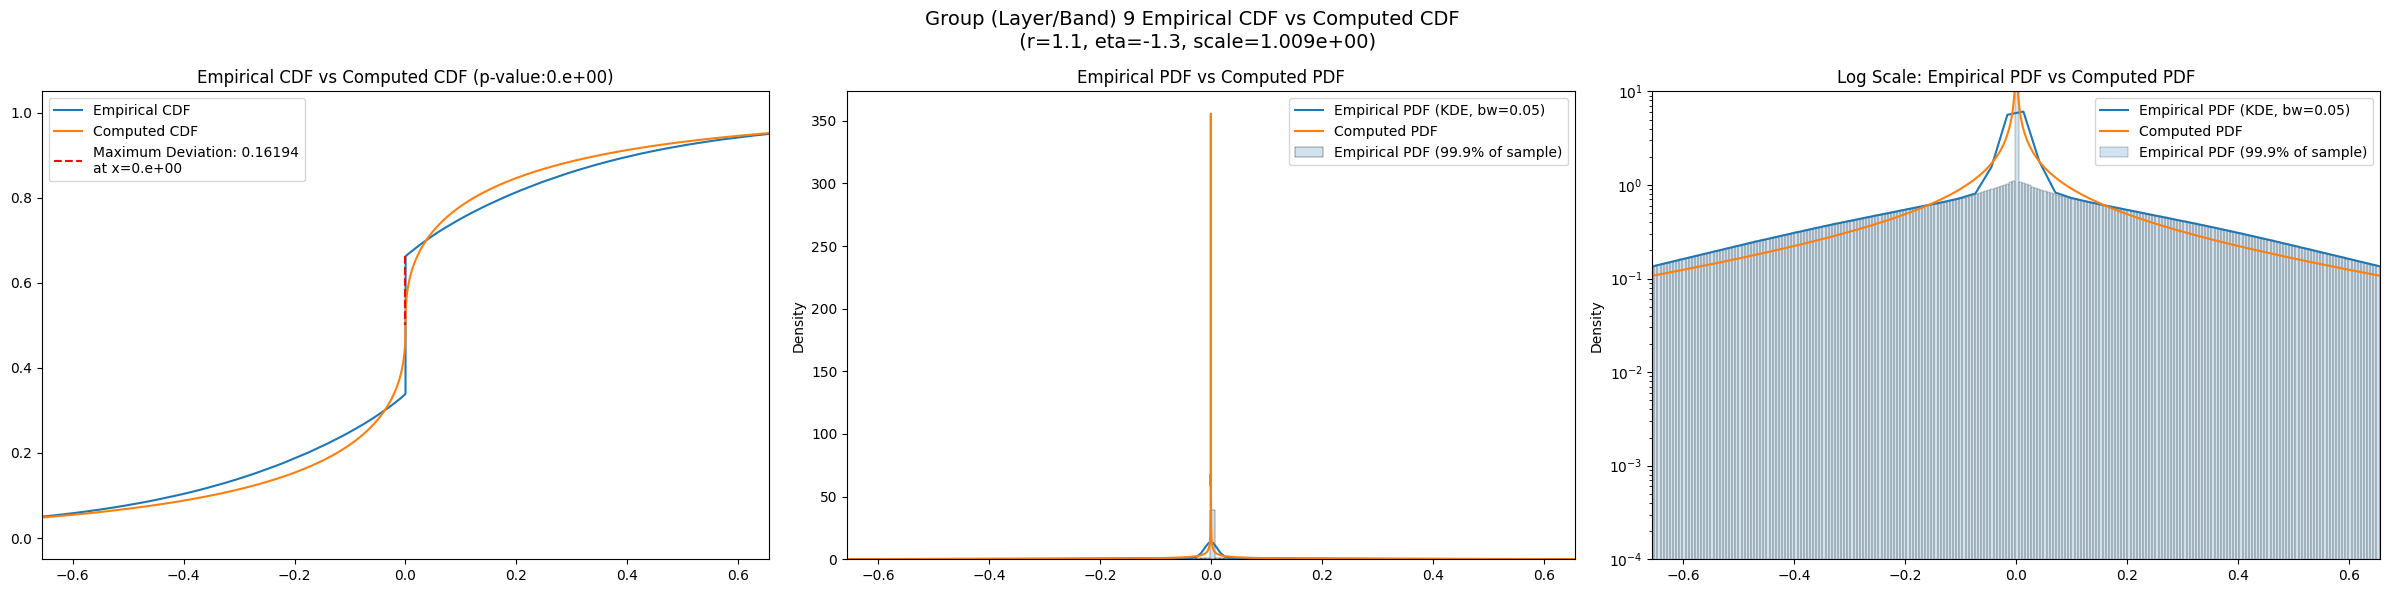

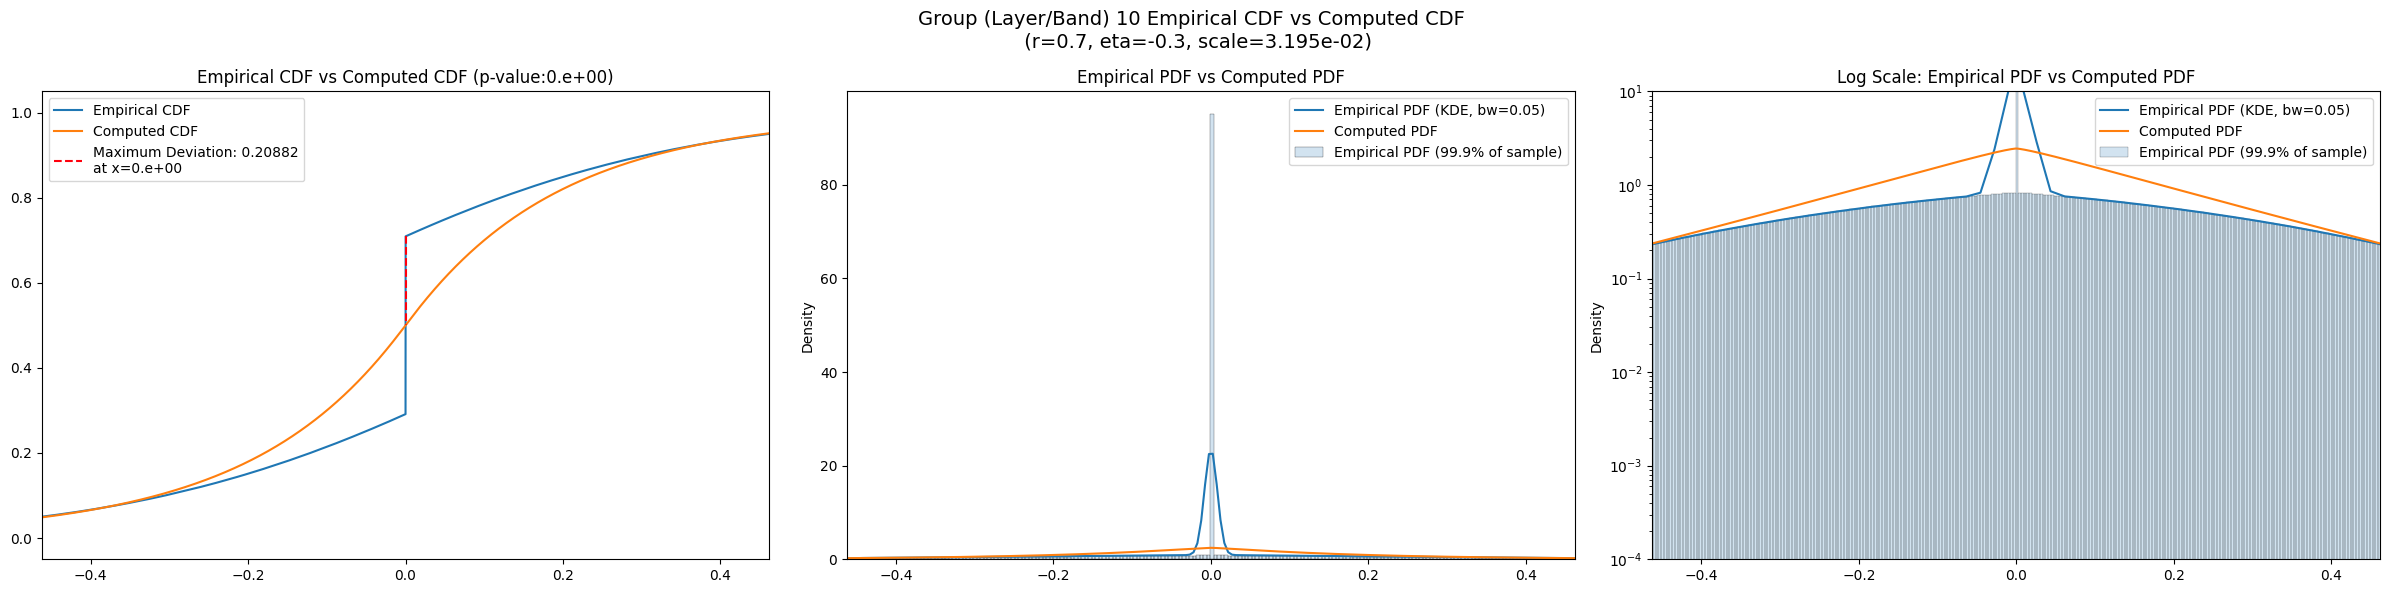

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper   obs_kurt  kurt_lower  \
layer                                                                 
2      3088.534400  2887.459200  3298.715600   2.768599    2.209898   
3       792.086700   742.734500   843.812900   4.083745    3.269665   
4       200.471950   186.644500   214.970100   5.411225    4.463559   
5        46.753990    43.335340    50.343990   6.637358    5.396938   
6        10.640573     9.781947    11.545038   8.303143    6.574237   
7         2.464533     2.255110     2.689189   9.776408    7.589888   
8         0.621601     0.566256     0.683546  11.310019    8.002231   
9         0.189849     0.173479     0.207935  10.419234    7.380879   
10        0.080307     0.074035     0.087240   8.073637    5.321874   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.385624           7072             0.008792        1.4         -0.8   
3        5.292534          28288             0.007429        1.2         -1.0   
4        6.504961         113152             0.009937        1.0         -1.1   
5        8.449866         452608             0.016880        1.3         -1.2   
6       11.259625        1810432             0.036720        2.0         -1.3   
7       14.029722        7241728             0.071410        1.1         -1.3   
8       23.276373       28966912             0.115320        1.1         -1.3   
9       20.614819      115867648             0.161940        1.1         -1.3   
10      15.430704      463470592             0.208820        0.7         -0.3   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       42.722500              0.040652          1.363390e-10   
3      ...       19.195500              0.049898          1.193750e-61   
4      ...        8.309120              0.062213          0.000000e+00   
5      ...        3.523060              0.071939          0.000000e+00   
6      ...        1.474790              0.079466          0.000000e+00   
7      ...        0.612919              0.089733          0.000000e+00   
8      ...        0.246922              0.115325          0.000000e+00   
9      ...        0.107312              0.161940          0.000000e+00   
10     ...        0.078422              0.208820          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          36.996100             0.015411         6.879970e-02  30.789900   
3          16.341900             0.025081         6.841560e-16  13.304300   
4           7.034910             0.037829        4.001140e-141   5.650490   
5           2.938280             0.049257         0.000000e+00   2.330280   
6           1.196530             0.059790         0.000000e+00   0.942463   
7           0.466665             0.076828         0.000000e+00   0.370013   
8           0.170911             0.115320         0.000000e+00   0.139554   
9           0.078422             0.161940         0.000000e+00   0.078423   
10          0.126888             0.208820         0.000000e+00   0.106166   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.022288   1.749710e-03          7.979767e-01  
3           0.030028   1.359830e-22          1.638253e-01  
4           0.042006  6.314010e-174          9.651234e-09  
5           0.052611   0.000000e+00         1.873930e-112  
6           0.062495   0.000000e+00          0.000000e+00  
7           0.078695   0.000000e+00          0.000000e+00  
8           0.115322   0.000000e+00          0.000000e+00  
9           0.161940   0.000000e+00          0.000000e+00  
10          0.208820   0.000000e+00          0.000000e+00  

[9 rows x 30 

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.008792                 0.016126          0.007660   
3                 0.007429                 0.008069          0.006644   
4                 0.009937                 0.004036          0.009197   
5                 0.016880                 0.002018          0.016880   
6                 0.036720                 0.001009          0.036720   
7                 0.071410                 0.000505          0.071410   
8                 0.115320                 0.000252          0.115320   
9                 0.161940                 0.000126          0.161940   
10                0.208820                 0.000063          0.208820   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.040652             0.015411       0.022288  
3                  0.049898             0.025081       0.030028  
4                  0.062213             0.037829       0.042006  
5                  0.071939             0.049257       0.052611  
6                  0.079466             0.059790       0.062495  
7                  0.089733             0.076828       0.078695  
8                  0.115325             0.115320       0.115322  
9                  0.161940             0.161940       0.161940  
10                 0.208820             0.208820       0.208820

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta   best_scale  \
layer                                                                        
2             3088.534424          0.007660    1.70     -0.84  6965.564615   
3              792.086670          0.006644    1.60     -1.04  2340.555329   
4              196.059143          0.009197    1.40     -1.14   678.239859   
5               43.431717          0.016880    1.21     -1.20   165.095489   
6               10.640573          0.036720    2.00     -1.30    67.975890   
7                2.464533          0.071410    1.10     -1.30    13.102503   
8                0.621601          0.115320    1.10     -1.30     3.304693   
9                0.189849          0.161940    1.10     -1.30     1.009318   
10               0.080307          0.208820    0.70     -0.30     0.031950   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                     25.0  
5                    100.0  
6                      0.0  
7                      0.0  
8                      0.0  
9                      0.0  
10                     0.0

In [21]:
eng.quit()